In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D, BatchNormalization,Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape

(50000, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(49582, 2)

In [9]:
def data_processing(text):
    text = text.lower()
    #text = TextBlob(text).correct().string
    text = re.sub(r"https?://\S+", '',text, flags=re.MULTILINE)#remove urls
    text = re.sub(r'\@w+|\#','',text)#remove hashtags and mentions
    text = re.sub(r'[^\w\s]','',text)#remove panctuations
    text_tokens = word_tokenize(text)#split the sentence
    filtered_text = [w for w in text_tokens if not w in stop_words]#remove stopwords
    return " ".join(filtered_text)

In [10]:
df['review'] = df['review'].apply(data_processing)

In [11]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [12]:
df['review'] = df['review'].apply(stemming)

In [13]:
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [14]:
pos_tweets = df[df.sentiment == "positive"]
pos_tweets.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
4,petter matteis love time money visually stunni...,positive
5,probably alltime favorite movie story selfless...,positive


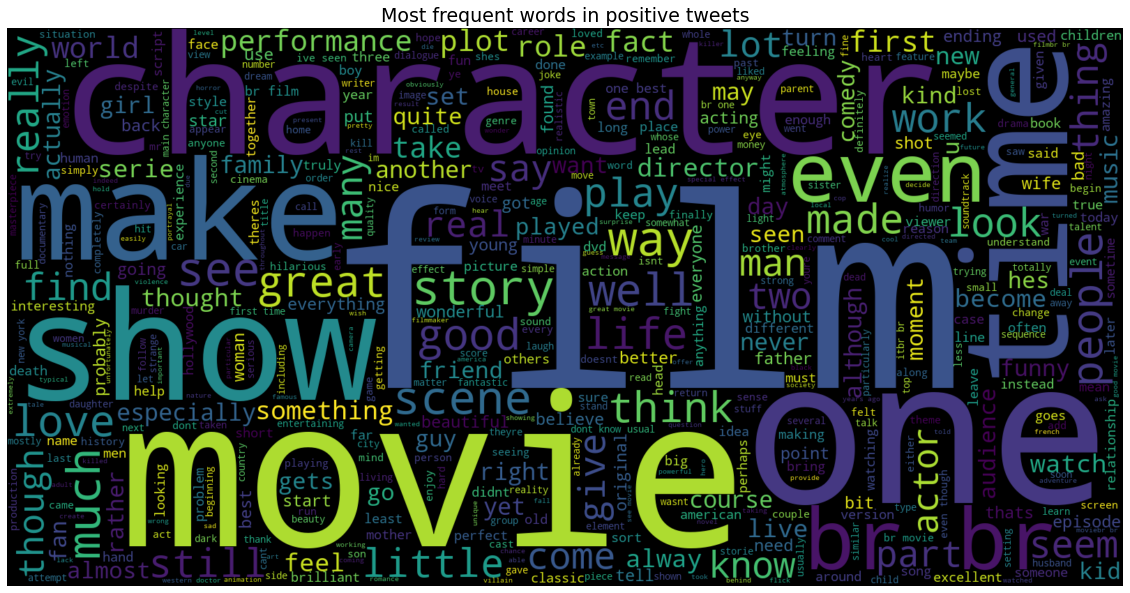

In [15]:
text = ' '.join([word for word in pos_tweets['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [16]:
neg_tweets = df[df.sentiment == "negative"]
neg_tweets.head()

,review,sentiment
3,basically theres family little boy jake thinks...,negative
7,show amazing fresh innovative idea 70s first a...,negative
8,encouraged positive comments film looking forw...,negative
10,phil alien one quirky films humour based aroun...,negative
11,saw movie 12 came recall scariest scene big bi...,negative


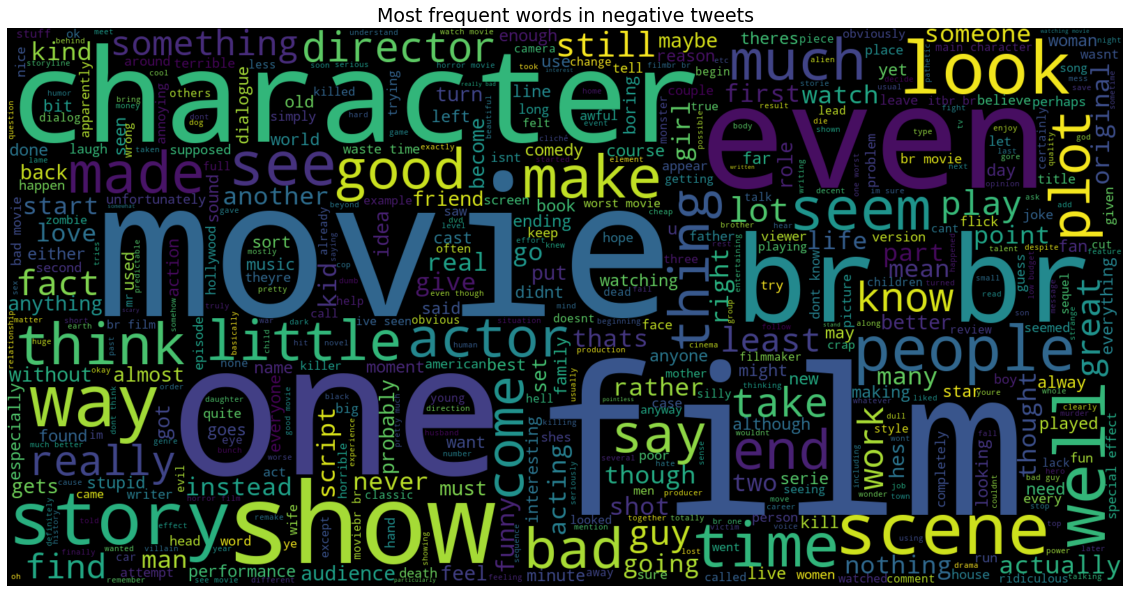

In [17]:
text = ' '.join([word for word in neg_tweets['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [18]:
mapping = {"positive" : 1, "negative" : 0}
df['sentiment'] = df['sentiment'].replace(mapping)

In [19]:
df['sentiment'].value_counts()

1    24884
0    24698
Name: sentiment, dtype: int64

In [20]:
vect = CountVectorizer(ngram_range=(1,2)).fit(df['review'])
feature_names = vect.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
X = df['review']
X = vect.transform(X)
Y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [22]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 90.04%


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
X = df['review']
Y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [24]:
max_len = max([len(x) for x in X])
print(max_len)

9334


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=42)

In [26]:
#Tokenize the sentences
tokenizer = Tokenizer()
#preparing vocabulary
tokenizer.fit_on_texts(x_train)
#converting text into integer sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
#padding to prepare sequences of same length
x_train = pad_sequences(x_train,maxlen=max_len)
x_test = pad_sequences(x_test,maxlen=max_len)


In [27]:
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

179517


In [30]:
model = Sequential()
#embedding layer
model.add(Embedding(size_of_vocabulary,128,input_length=max_len))
#model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
#Add loss function, metrics, optimizer
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#Adding callbacks
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)
#summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 9334, 128)         22978176  
                                                                 
 dropout (Dropout)           (None, 9334, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1194752)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1194753   
                                                                 
Total params: 24,172,929
Trainable params: 24,172,929
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(x_train, y_train,batch_size=64,epochs=5,
                    validation_data=(x_test, y_test),verbose=1,callbacks=[es,mc])

Epoch 1/5
766/767 [============================>.] - ETA: 0s - loss: 0.3984 - accuracy: 0.8282
Epoch 1: val_accuracy improved from -inf to 0.90323, saving model to best_model.h5
767/767 [==============================] - 36s 47ms/step - loss: 0.3981 - accuracy: 0.8283 - val_loss: 0.2497 - val_accuracy: 0.9032
Epoch 2/5
767/767 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9560
Epoch 2: val_accuracy did not improve from 0.90323
767/767 [==============================] - 35s 46ms/step - loss: 0.1292 - accuracy: 0.9560 - val_loss: 0.2576 - val_accuracy: 0.9032
Epoch 3/5
766/767 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9912
Epoch 3: val_accuracy did not improve from 0.90323
767/767 [==============================] - 35s 46ms/step - loss: 0.0396 - accuracy: 0.9912 - val_loss: 0.2824 - val_accuracy: 0.8911
Epoch 4/5
767/767 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9986
Epoch 4: val_accuracy did not improv